In [254]:
import os
import contextily as ctx
import geopandas as gpd
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import sqrt
from scipy.spatial import cKDTree
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
from scipy.stats import zscore
from statsmodels import robust
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from logger import ExperimentLogger
from sklearn.feature_selection import SelectFromModel

# Random Forest

## Load data

In [255]:
well_filter = 1

current_dir = os.getcwd()
data_path = os.path.join(current_dir, '../../data/aligned', f"merged_dataset_{well_filter}_ahn_elevation.csv") # _google_elevation
df = pd.read_csv(data_path)
print(len(df))

7620


In [256]:
df.columns

Index(['bro-id', 'nitrate', 'geometry', 'date', 'landuse code', 'soil region',
       'population', 'elevation', 'lon', 'lat', 'precipitation', 'temperature',
       'n deposition', 'mainsoilclassification_1', 'organicmattercontent_1',
       'density_1', 'acidity_1', 'minimumacidity_1', 'maximumacidity_1',
       'cnratio_1', 'peattype_1', 'calciccontent_1', 'fedith_1',
       'loamcontent_1', 'minimumloamcontent_1', 'maximumloamcontent_1',
       'sandmedian_1', 'minimumsandmedian_1', 'maximumsandmedian_1',
       'siltcontent_1', 'groundwater_depth'],
      dtype='object')

## Sort by date

In [257]:
# sort by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)
len(df)

7620

## Feature engineering

In [258]:
# df['month_sin'] = np.sin(2*np.pi*df['date'].dt.month/12)
# df['month_cos'] = np.cos(2*np.pi*df['date'].dt.month/12)

In [259]:
df.columns

Index(['bro-id', 'nitrate', 'geometry', 'date', 'landuse code', 'soil region',
       'population', 'elevation', 'lon', 'lat', 'precipitation', 'temperature',
       'n deposition', 'mainsoilclassification_1', 'organicmattercontent_1',
       'density_1', 'acidity_1', 'minimumacidity_1', 'maximumacidity_1',
       'cnratio_1', 'peattype_1', 'calciccontent_1', 'fedith_1',
       'loamcontent_1', 'minimumloamcontent_1', 'maximumloamcontent_1',
       'sandmedian_1', 'minimumsandmedian_1', 'maximumsandmedian_1',
       'siltcontent_1', 'groundwater_depth'],
      dtype='object')

## Remove some columns and rows

--> By dropping Nan we exclude nitrate points that fall under city areas

In [260]:
# df = df.drop(columns=['soil region', 'peattype_1', 'calciccontent_1', 'fedith_1', 'loamcontent_1', 'minimumloamcontent_1', 'minimumsandmedian_1', 'siltcontent_1'])
# df = df.drop(columns=['landuse code'])
# df = df.drop(columns=['soil region', 'peattype_1'])
df = df.drop(columns=['peattype_1'])

df = df.dropna()
len(df)

# df = df.dropna(subset=['acidity_1'])
# len(df)

5341

## Add month and year as a feature

In [261]:
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

In [262]:
# def add_neighbor_mean(df, value_col='nitrate', n_neighbors=2):
#     # Make a copy to avoid modifying the original
#     df = df.copy()
#     df['neighbor_mean'] = np.nan
    
#     # Group by year and month
#     for (year, month), group in df.groupby(['year', 'month']):
#         # Use only wells with valid lat/lon and value
#         mask = group[['lon', 'lat', value_col]].notnull().all(axis=1)
#         wells = group[mask]
#         if len(wells) < n_neighbors + 1:
#             continue  # Not enough data
        
#         coords = wells[['lon', 'lat']].values
#         tree = cKDTree(coords)
        
#         # For each well in this (year, month), find nearest neighbors
#         for idx, row in wells.iterrows():
#             # Query for n_neighbors+1 because the first neighbor is itself
#             dists, indices = tree.query([row['lon'], row['lat']], k=n_neighbors+1)
#             # Exclude itself (distance==0)
#             neighbor_indices = indices[1:n_neighbors+1]
#             neighbor_vals = wells.iloc[neighbor_indices][value_col].values
#             mean_val = np.mean(neighbor_vals)
#             df.at[idx, 'neighbor_mean'] = mean_val
    
#     return df

# df = add_neighbor_mean(df, value_col='nitrate', n_neighbors=2)

# df = df.dropna()
# len(df)

## Change column type

In [263]:
for col in ['soil region', 'landuse code', 'mainsoilclassification_1']:
    if col in df.columns:
        df[col] = df[col].astype('category')

## Remove nitrate outliers

<Axes: >

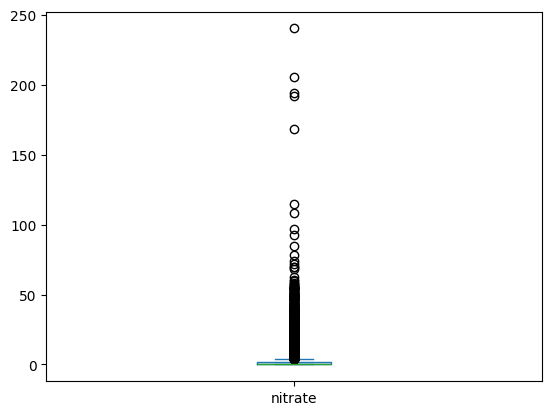

In [264]:
df[["nitrate"]].plot(kind = "box")

<Axes: >

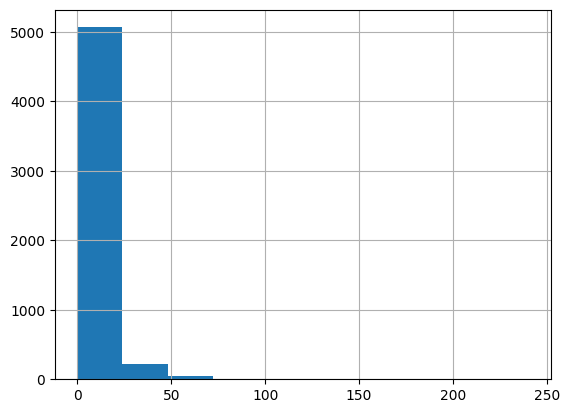

In [265]:
df["nitrate"].hist()

In [266]:
len(df[df["nitrate"] >= 58])

20

## Test / train split

In [267]:
outlier_method = "manual_removal"
top_nitrate_outliers = list(df["nitrate"].sort_values()[-20:].index)
top_nitrate_outliers
df = df.drop(top_nitrate_outliers)
len(df)

5321

In [268]:
# Define the split by year
train_years = list(range(2008, 2021))
test_years = [2021, 2022, 2023]

# Filter datasets
train_df = df[df["year"].isin(train_years)].copy()
test_df = df[df["year"].isin(test_years)].copy()

print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")

Train: 4439
Test: 882


## Outliers

Select method that works the best

In [269]:
# def get_outlier_mask(s, method='iqr', factor=1.5, z_thresh=3, mad_thresh=3.5, 
#                      lower_pct=0.01, upper_pct=0.99, contamination=0.01, X=None, 
#                      dbscan_eps=0.5, dbscan_min_samples=5, domain_range=None):

#     if method == 'iqr':
#         q1, q3 = s.quantile([0.25, 0.75])
#         iqr = q3 - q1
#         lower, upper = q1 - factor * iqr, q3 + factor * iqr
#         return (s >= lower) & (s <= upper)

#     elif method == 'zscore':
#         z = zscore(s, nan_policy='omit')
#         return np.abs(z) < z_thresh

#     elif method == 'mad':
#         median = np.median(s)
#         mad = robust.mad(s)
#         z = 0.6745 * (s - median) / mad if mad else np.zeros_like(s)
#         return np.abs(z) < mad_thresh

#     elif method == 'percentile':
#         lower, upper = s.quantile([lower_pct, upper_pct])
#         return (s >= lower) & (s <= upper)

#     elif method == 'isoforest':
#         if X is None: raise ValueError("X (DataFrame) required for Isolation Forest.")
#         iso = IsolationForest(contamination=contamination, random_state=42)
#         outlier_pred = iso.fit_predict(X)
#         return outlier_pred == 1

#     elif method == 'lof':
#         if X is None: raise ValueError("X (DataFrame) required for LOF.")
#         lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
#         outlier_pred = lof.fit_predict(X)
#         return outlier_pred == 1

#     elif method == 'dbscan':
#         if X is None: raise ValueError("X (DataFrame) required for DBSCAN.")
#         db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples).fit(X)
#         return db.labels_ != -1

#     elif method == 'domain':
#         if domain_range is None: raise ValueError("Specify domain_range=(min, max) for 'domain' method.")
#         lower, upper = domain_range
#         return (s >= lower) & (s <= upper)

#     else:
#         raise ValueError(f"Unknown outlier removal method: {method}")


# outlier_method = "iqr"  # or "zscore", "mad", "percentile", "isoforest", etc.
# lower, upper = 0, 100
# domain_range=(lower, upper)

# # Univariate example (apply only to train, get bounds, then apply same to test)
# mask_train = get_outlier_mask(train_df['nitrate'], method=outlier_method, X=train_df)
# lb, ub = train_df.loc[mask_train, 'nitrate'].min(), train_df.loc[mask_train, 'nitrate'].max()  # For some methods, like IQR

# train_df = train_df[mask_train]
# test_df = test_df[(test_df['nitrate'] >= lb) & (test_df['nitrate'] <= ub)]

# print(f"Train rows after outlier filter: {len(train_df):,}")
# print(f"Test  rows after outlier filter: {len(test_df):,}")


In [270]:
# def iqr_bounds(s, factor: float = 1.5):
#     """Return (lower, upper) IQR bounds for a Series."""
#     q1, q3 = s.quantile([0.25, 0.75])
#     iqr = q3 - q1
#     return q1 - factor * iqr, q3 + factor * iqr

# lb, ub = iqr_bounds(train_df['nitrate'])      # ← only training stats
# train_df = train_df[(train_df['nitrate'] >= lb) & (train_df['nitrate'] <=  ub)]
# test_df  = test_df [(test_df ['nitrate'] >= lb) & (test_df ['nitrate'] <=  ub)]

# print(f"Train rows after outlier filter: {len(train_df):,}")
# print(f"Test  rows after outlier filter: {len(test_df):,}")

In [271]:
X_train = train_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_train = train_df["nitrate"]

X_test = test_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_test = test_df["nitrate"]

## Preprocess data

In [272]:
categorical_cols = X_train.select_dtypes(include="category").columns.tolist()
numerical_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()

In [273]:
print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)
print("All X_train columns:", X_train.columns.tolist())

Categorical: ['landuse code', 'soil region', 'mainsoilclassification_1']
Numerical: ['population', 'elevation', 'precipitation', 'temperature', 'n deposition', 'organicmattercontent_1', 'density_1', 'acidity_1', 'minimumacidity_1', 'maximumacidity_1', 'cnratio_1', 'calciccontent_1', 'fedith_1', 'loamcontent_1', 'minimumloamcontent_1', 'maximumloamcontent_1', 'sandmedian_1', 'minimumsandmedian_1', 'maximumsandmedian_1', 'siltcontent_1', 'groundwater_depth']
All X_train columns: ['landuse code', 'soil region', 'population', 'elevation', 'precipitation', 'temperature', 'n deposition', 'mainsoilclassification_1', 'organicmattercontent_1', 'density_1', 'acidity_1', 'minimumacidity_1', 'maximumacidity_1', 'cnratio_1', 'calciccontent_1', 'fedith_1', 'loamcontent_1', 'minimumloamcontent_1', 'maximumloamcontent_1', 'sandmedian_1', 'minimumsandmedian_1', 'maximumsandmedian_1', 'siltcontent_1', 'groundwater_depth']


In [274]:
preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    # ("num_scaler", StandardScaler(), numerical_cols)
    ("num_scaler", MinMaxScaler(), numerical_cols)
])

## Initialize model

In [275]:
rf_model = RandomForestRegressor(random_state=123, oob_score=False)

number_of_features = 20
selector = SelectFromModel(RandomForestRegressor(n_estimators=number_of_features, random_state=123), threshold="median")

In [276]:
pipe = Pipeline([
    ("prep", preprocessor),
    ("feature_select", selector),
    ("rf", rf_model)
])

full_pipeline = TransformedTargetRegressor(
    regressor=pipe,
    # func=np.log1p,
    # inverse_func=np.expm1
)

In [277]:
# param_grid = {
#     "regressor__rf__n_estimators": [50, 70, 100, 150],
#     "regressor__rf__max_features": ["sqrt", 0.2, 0.5, 0.7],
#     "regressor__rf__max_depth": [None, 5, 8, 10],
#     "regressor__rf__min_samples_split": [2, 4, 6, 8],
#     "regressor__rf__min_samples_leaf": [3, 4, 5]
# }

param_grid = {
    'regressor__rf__n_estimators': [30, 50, 75, 100, 150],
    'regressor__rf__max_depth': [10, 15, 20, None],
    'regressor__rf__min_samples_split': [2, 4, 8, 10],
    'regressor__rf__min_samples_leaf': [1, 2, 4, 6],
    'regressor__rf__max_features': ['sqrt', 0.15, 0.3, 0.5]
}

# param_grid = {
#     'regressor__rf__n_estimators': [100],
#     'regressor__rf__max_depth': [20],
#     'regressor__rf__min_samples_split': [2],
#     'regressor__rf__min_samples_leaf': [1],
#     'regressor__rf__max_features': [0.15]
# }

## Hyperparameter tuning

In [278]:
tscv = TimeSeriesSplit(n_splits=5)

scoring = {
    'R2': 'r2',
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False)
}

search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_grid,
    n_iter=60,
    cv=tscv,
    # scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    scoring=scoring,                # <-- dictionary!
    refit='R2',                     # <-- which metric to optimize
    n_jobs=-1,
    random_state=123,
    verbose=1
)

# search.fit(X_train, y_train, **fit_params)

search.fit(X_train, y_train)
best_model = search.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [279]:
print("Best CV MAE:", search.best_score_)
print("Best params:", search.best_params_)

Best CV MAE: 0.6550740249335715
Best params: {'regressor__rf__n_estimators': 100, 'regressor__rf__min_samples_split': 4, 'regressor__rf__min_samples_leaf': 1, 'regressor__rf__max_features': 'sqrt', 'regressor__rf__max_depth': None}


In [280]:
# save model

import joblib
joblib.dump(best_model, '../../trained_models/new_rf_notebook.pkl')

['../../trained_models/new_rf_notebook.pkl']

## Learning curve

In [281]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [282]:
n = len(X_train)

train_errors = []
val_errors = []
train_stds = []
val_stds = []

for frac in train_sizes:
    split_idx = int(frac * n)
    X_subset = X_train.iloc[:split_idx]
    y_subset = y_train.iloc[:split_idx]
    # w_subset = sample_weight.iloc[:split_idx].values

    tscv = TimeSeriesSplit(n_splits=5)
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_subset):
        X_tr, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
        y_tr, y_val = y_subset.iloc[train_idx], y_subset.iloc[val_idx]
        # w_tr = w_subset[train_idx]

        model = clone(best_model)
        model.fit(X_tr, y_tr)

        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        fold_train_scores.append(mean_absolute_error(y_tr, y_tr_pred))
        fold_val_scores.append(mean_absolute_error(y_val, y_val_pred))

    # Store mean and std
    train_errors.append(np.mean(fold_train_scores))
    val_errors.append(np.mean(fold_val_scores))
    train_stds.append(np.std(fold_train_scores))
    val_stds.append(np.std(fold_val_scores))

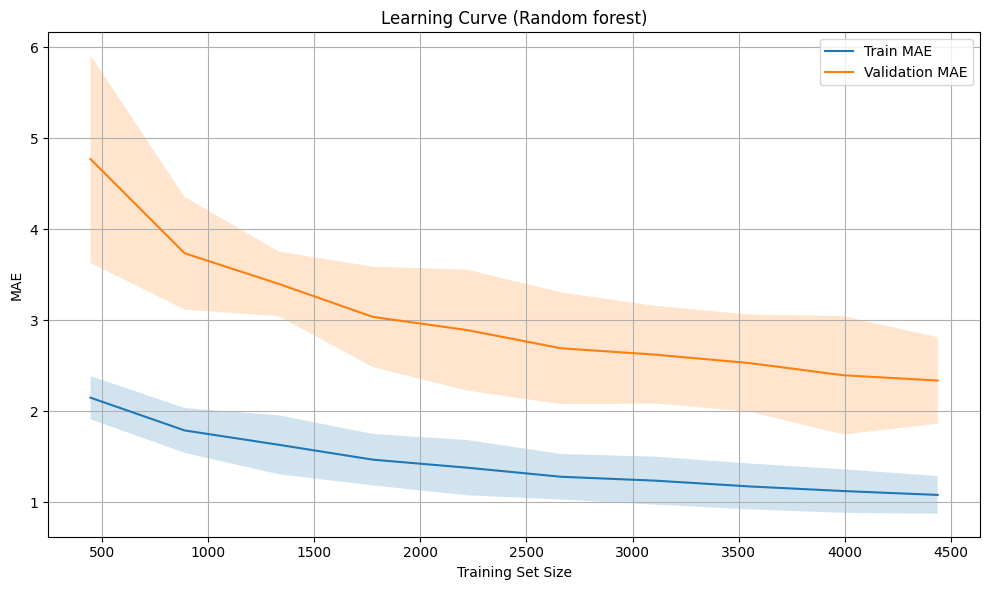

In [283]:
train_sizes_abs = train_sizes * len(X_train)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_errors, label="Train MAE")
plt.fill_between(train_sizes_abs, 
                 np.array(train_errors) - np.array(train_stds),
                 np.array(train_errors) + np.array(train_stds),
                 alpha=0.2)

plt.plot(train_sizes_abs, val_errors, label="Validation MAE")
plt.fill_between(train_sizes_abs, 
                 np.array(val_errors) - np.array(val_stds),
                 np.array(val_errors) + np.array(val_stds),
                 alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("MAE")
plt.title("Learning Curve (Random forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

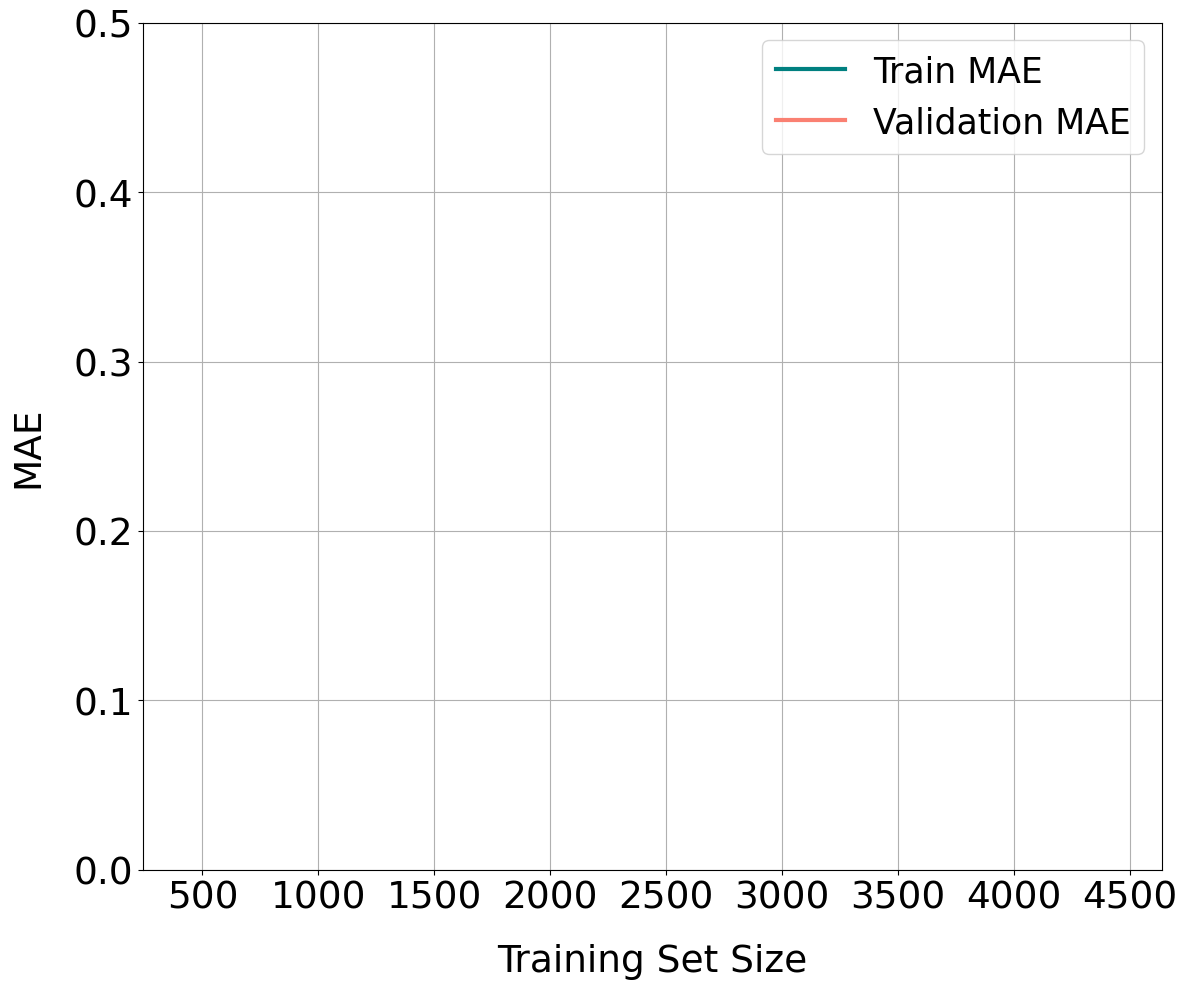

In [284]:
import matplotlib.pyplot as plt

train_sizes_abs = train_sizes * len(X_train)

plt.figure(figsize=(12, 10))

# Plot lines with custom colors
plt.plot(train_sizes_abs, train_errors, label="Train MAE", color="teal", linewidth=3)  
plt.fill_between(train_sizes_abs, 
                 np.array(train_errors) - np.array(train_stds),
                 np.array(train_errors) + np.array(train_stds),
                 alpha=0.2, color="teal")

plt.plot(train_sizes_abs, val_errors, label="Validation MAE", color="salmon", linewidth=3)
plt.fill_between(train_sizes_abs, 
                 np.array(val_errors) - np.array(val_stds),
                 np.array(val_errors) + np.array(val_stds),
                 alpha=0.2, color="salmon")

# Increase font sizes
plt.xlabel("Training Set Size", fontsize=27, labelpad=20)
plt.ylabel("MAE", fontsize=27, labelpad=20)
# plt.title("Learning Curve (Random Forest)", fontsize=16)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.legend(fontsize=25)
plt.ylim(0, 0.5)  # Set fixed y-axis range
plt.grid(True)
plt.tight_layout()
plt.show()


## Train model

In [285]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['landuse '
                                                                                        'code',
                                                                                        'soil '
                                                                                        'region',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       MinMaxScaler(),
                                                                                       ['population',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'deposition',
                                                                                        'organicmattercontent_1',...
                                                                                        'minimumloamcontent_1',
                                                                                        'maximumloamcontent_1',
                                                                                        'sandmedian_1',
                                                                                        'minimumsandmedian_1',
                                                                                        'maximumsandmedian_1',
                                                                                        'siltcontent_1',
                                                                                        'groundwater_depth'])])),
                                                     ('feature_select',
                                                      SelectFromModel(estimator=RandomForestRegressor(n_estimators=20,
                                                                                                      random_state=123),
                                                                      threshold='median')),
                                                     ('rf',
                                                      RandomForestRegressor(max_features='sqrt',
                                                                            min_samples_split=4,
                                                                            random_state=123))]))

## Final Train score

In [286]:
pred_train = best_model.predict(X_train)

train_r2 = r2_score(y_train, pred_train)
train_mae = mean_absolute_error(y_train, pred_train)
train_rmse = sqrt(mean_squared_error(y_train, pred_train))

print("Train R2:", r2_score(y_train, pred_train))
print("Train MAE:", mean_absolute_error(y_train, pred_train))
print("Test RMSE:", sqrt(mean_squared_error(y_train, pred_train)))

Train R2: 0.9406315219006034
Train MAE: 0.8432335871732832
Test RMSE: 2.0959177413740693


## Final Test score

In [287]:
pred_nitrate = best_model.predict(X_test)

test_r2 = r2_score(y_test, pred_nitrate)
test_mae = mean_absolute_error(y_test, pred_nitrate)
test_rmse = sqrt(mean_squared_error(y_test, pred_nitrate))

print("Test R2:", test_r2)
print("Test MAE:", test_mae)
print("Test RMSE:", test_rmse)

Test R2: 0.6392691424652693
Test MAE: 2.140123093560005
Test RMSE: 5.202989347162144


In [288]:
# Convert to Series and save
pd.Series(pred_nitrate).to_csv('test_pred_nitrate_rf.csv', index=False)
pd.Series(y_test).to_csv('y_test.csv', index=False)

## Calibration

In [289]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(pred_nitrate.reshape(-1, 1), y_test)

# Apply calibration to predictions
y_calibrated = lr.predict(pred_nitrate.reshape(-1, 1))

In [290]:
calib_test_r2 = r2_score(y_test, y_calibrated)
calib_test_mae = mean_absolute_error(y_test, y_calibrated)
calib_test_rmse = sqrt(mean_squared_error(y_test, y_calibrated))

print("Test R2:", calib_test_r2)
print("Test MAE:", calib_test_mae)
print("Test RMSE:", calib_test_rmse)

Test R2: 0.6438695081930892
Test MAE: 2.138802513967455
Test RMSE: 5.169706282852779


## Real vs Predicted

<Axes: xlabel='nitrate', ylabel='nitrate'>

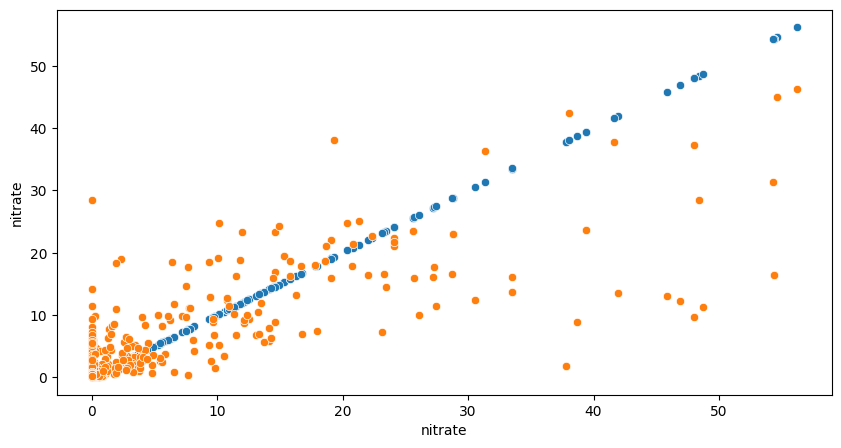

In [291]:
fix, ax = plt.subplots(figsize= (10,5))

sns.scatterplot(x = y_test, y = y_test, ax = ax)
sns.scatterplot(x = y_test, y = pred_nitrate, ax = ax)

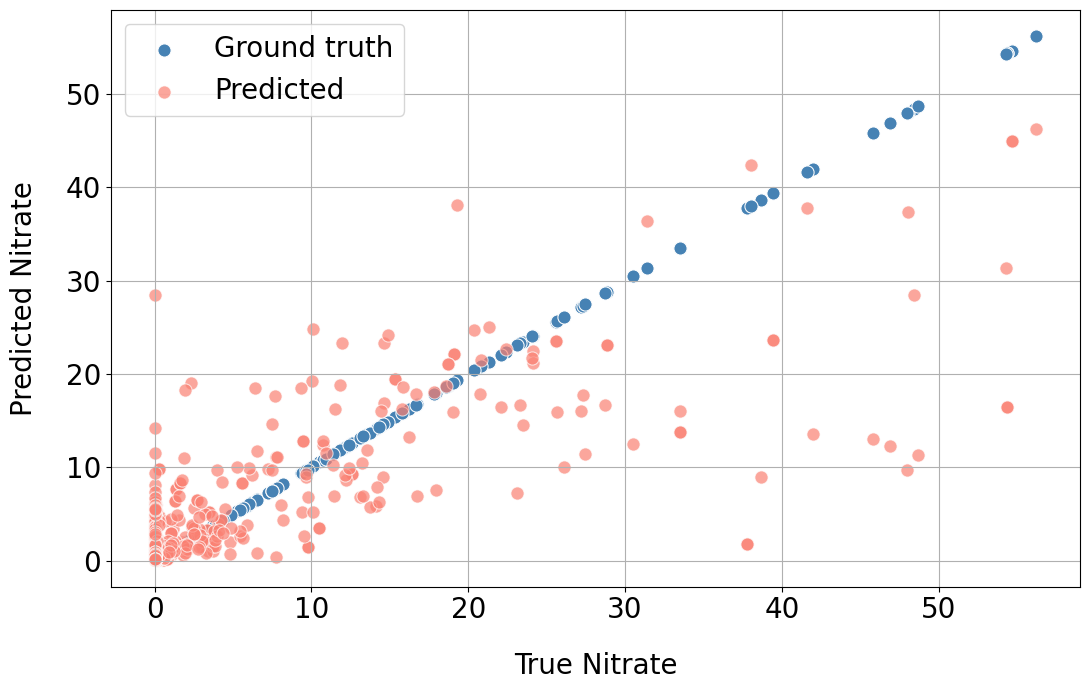

In [292]:
fig, ax = plt.subplots(figsize=(11, 7))

# Ground truth (diagonal reference line)
sns.scatterplot(x=y_test, y=y_test, ax=ax, label="Ground truth", s=90, color="steelblue")

# Model predictions
sns.scatterplot(x=y_test, y=pred_nitrate, ax=ax, label="Predicted", s=90, color="salmon", alpha=0.7)

# Labels and style
ax.set_xlabel("True Nitrate", fontsize=20, labelpad=20)
ax.set_ylabel("Predicted Nitrate", fontsize=20, labelpad=20)
ax.tick_params(labelsize=20)
ax.legend(fontsize=20)
ax.grid(True)

plt.tight_layout()
plt.show()

## Residuals

(-31.768115830357118, 12.0)

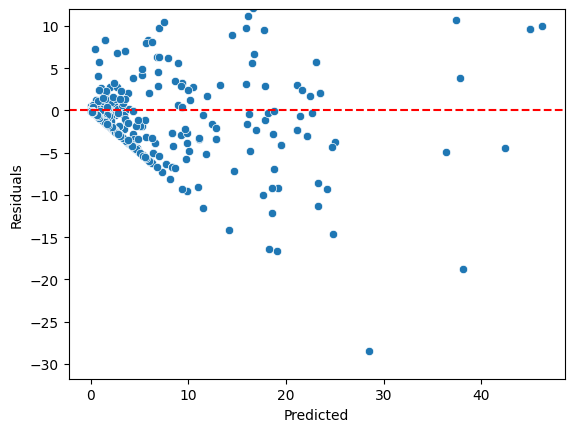

In [293]:
preds = best_model.predict(X_test)
residuals = y_test - preds
sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.ylim(top=12)

In [294]:
residuals.to_csv("rf_residuals.csv")

## Predictions on the map

In [295]:
coords = test_df[["lon", "lat"]].reset_index(drop=True)

print(len(coords['lon']))
print(len(coords['lat']))
print(len(np.expm1(pred_nitrate)))
print(len(np.expm1(y_test)))

882
882
882
882


In [296]:
#extract 'lon' and 'lat' from test_df
coords = test_df[["lon", "lat"]].reset_index(drop=True)

# construct new dataframe with predictions, real values and locations
gdf = gpd.GeoDataFrame({
    'lon': coords['lon'],
    'lat': coords['lat'],
    'nitrate_pred': pred_nitrate,
    'nitrate_true': y_test.reset_index(drop=True)
}, geometry=gpd.points_from_xy(coords["lon"], coords["lat"]))

gdf.crs = "EPSG:4326"

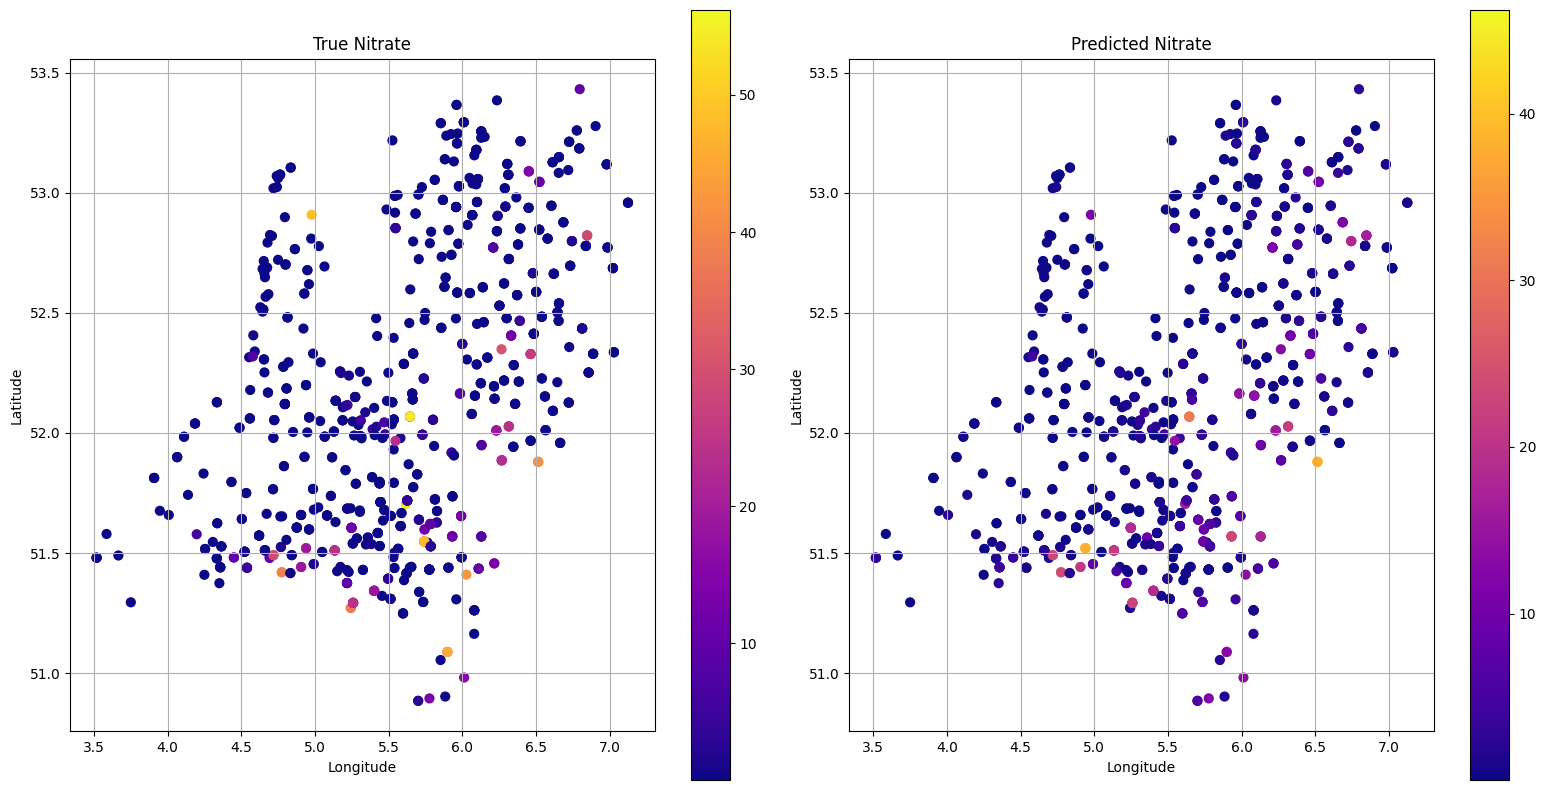

In [297]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
axs[0].set_title("True Nitrate")

gdf.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

plt.tight_layout()
plt.show()

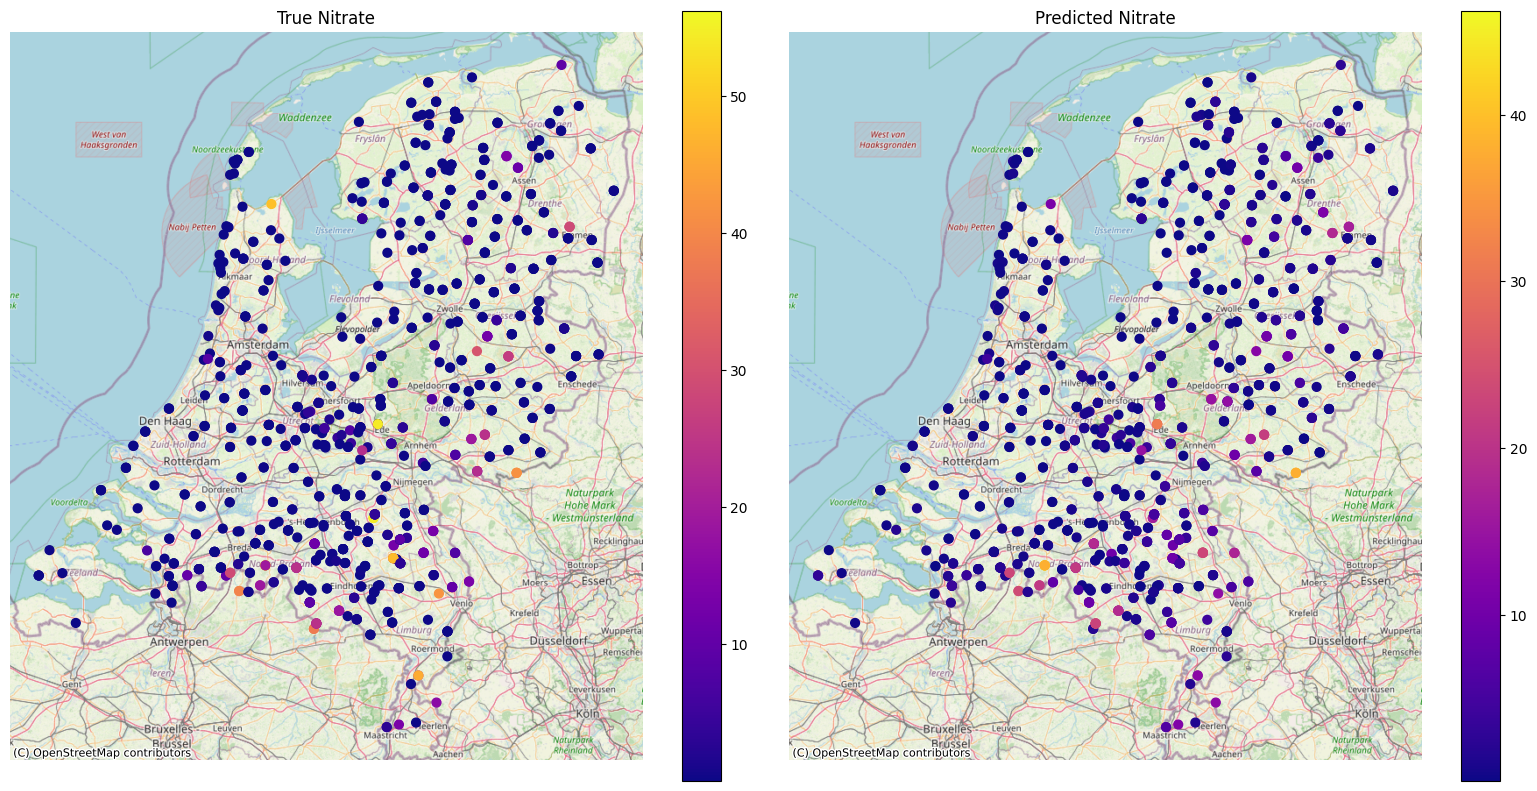

In [298]:
gdf_3857 = gdf.to_crs(epsg=3857)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf_3857.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)
axs[0].set_title("True Nitrate")

gdf_3857.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

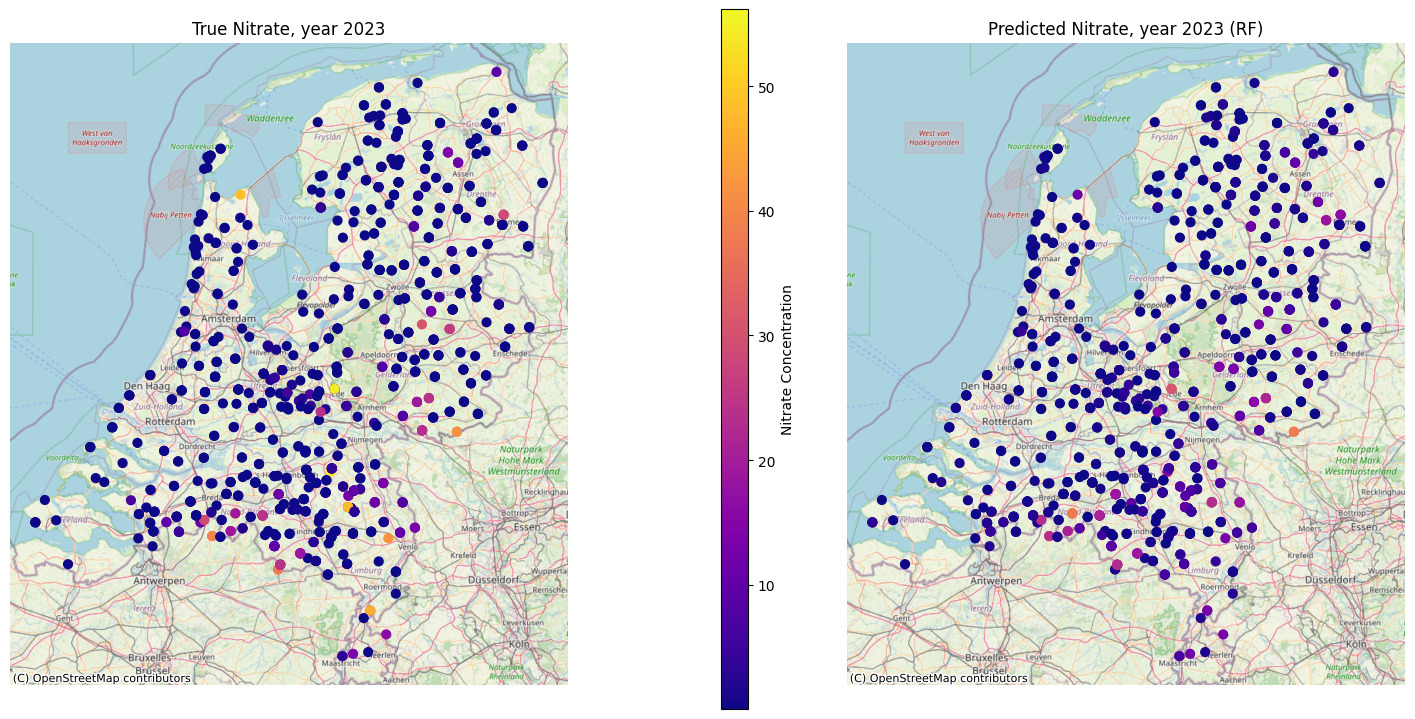

In [299]:
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Reproject
gdf_3857 = gdf.to_crs(epsg=3857)

# Shared color range
vmin = min(gdf_3857["nitrate_true"].min(), gdf_3857["nitrate_pred"].min())
vmax = max(gdf_3857["nitrate_true"].max(), gdf_3857["nitrate_pred"].max())
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.plasma
sm = ScalarMappable(cmap=cmap, norm=norm)
sm._A = []

# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={"wspace": 0.5})  # less space between plots

# Plot
gdf_3857.plot(ax=axs[0], column="nitrate_true", cmap=cmap, norm=norm, legend=False, markersize=40)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)
axs[0].set_title("True Nitrate, year 2023")

gdf_3857.plot(ax=axs[1], column="nitrate_pred", cmap=cmap, norm=norm, legend=False, markersize=40)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)
axs[1].set_title("Predicted Nitrate, year 2023 (RF)")

for ax in axs:
    ax.set_axis_off()

# Add colorbar BETWEEN the subplots
cbar_ax = fig.add_axes([0.52, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
fig.colorbar(sm, cax=cbar_ax, label="Nitrate Concentration")

plt.show()


In [300]:
pipe = best_model.regressor_
preprocessor = pipe.named_steps['prep']
selector = pipe.named_steps['feature_select']

feature_names = preprocessor.get_feature_names_out()
selected_features = list(feature_names[selector.get_support()])

len(selected_features)

39

## Logging

In [301]:
curr_dir = os.getcwd()
log_path = os.path.join(curr_dir, '../../logging/experiment_log.json')

# After each notebook run, do this!
logger = ExperimentLogger(save_path=log_path)

# if not outlier_method:

model = "Random Forest"
hyperparams = search.best_params_
outlier_method = outlier_method
train_score = {"R2": train_r2, "MAE": train_mae, "RMSE": train_rmse}
test_score = {"R2": test_r2, "MAE": test_mae, "RMSE": test_rmse}
data_file_name = data_path
preprocessor = pipe.named_steps['prep']
feature_names = preprocessor.get_feature_names_out()

logger.log(
    model = model,
    data_file = data_file_name,
    features = number_of_features,
    hyperparams=hyperparams,
    outlier_method=outlier_method,
    train_score=train_score,
    test_score=test_score,
    extra_info={"note": "Removed soil region"}
)

{'model': 'Random Forest',
 'data_file': '/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/notebooks/models/../../data/aligned/merged_dataset_1_ahn_elevation.csv',
 'features': 20,
 'timestamp': '2025-07-13T13:26:02.147993',
 'hyperparameters': {'regressor__rf__n_estimators': 100,
  'regressor__rf__min_samples_split': 4,
  'regressor__rf__min_samples_leaf': 1,
  'regressor__rf__max_features': 'sqrt',
  'regressor__rf__max_depth': None},
 'outlier_method': 'manual_removal',
 'train_score': {'R2': 0.9406315219006034,
  'MAE': 0.8432335871732832,
  'RMSE': 2.0959177413740693},
 'test_score': {'R2': 0.6392691424652693,
  'MAE': 2.140123093560005,
  'RMSE': 5.202989347162144},
 'note': 'Removed soil region'}

## Feature importances

--> Gain (by default) how much each feature, on average, reduces the impurity (MSE or Gini)

In [302]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['landuse '
                                                                                        'code',
                                                                                        'soil '
                                                                                        'region',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       MinMaxScaler(),
                                                                                       ['population',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'deposition',
                                                                                        'organicmattercontent_1',...
                                                                                        'minimumloamcontent_1',
                                                                                        'maximumloamcontent_1',
                                                                                        'sandmedian_1',
                                                                                        'minimumsandmedian_1',
                                                                                        'maximumsandmedian_1',
                                                                                        'siltcontent_1',
                                                                                        'groundwater_depth'])])),
                                                     ('feature_select',
                                                      SelectFromModel(estimator=RandomForestRegressor(n_estimators=20,
                                                                                                      random_state=123),
                                                                      threshold='median')),
                                                     ('rf',
                                                      RandomForestRegressor(max_features='sqrt',
                                                                            min_samples_split=4,
                                                                            random_state=123))]))

In [303]:
if isinstance(best_model, TransformedTargetRegressor):
    print("Yes, this is a TransformedTargetRegressor.")
else:
    print("Nope, it's not.")

Yes, this is a TransformedTargetRegressor.


In [304]:
# 1. Get pipeline from best_model
pipe = best_model.regressor_

# 2. Get fitted preprocessor
fitted_preprocessor = pipe.named_steps['prep']

# 3. Get feature selector
selector = pipe.named_steps['feature_select']

# 4. Get fitted RF model
fitted_model = pipe.named_steps['rf']

# 5. Get feature names after preprocessing
feature_names = fitted_preprocessor.get_feature_names_out()

# 6. Mask for features selected
selected_mask = selector.get_support()

# 7. Names and importances of selected features
selected_features = feature_names[selected_mask]
importances = fitted_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)


                                              feature  importance
38                      num_scaler__groundwater_depth    0.137533
19                              num_scaler__elevation    0.089827
13  cat_ohe__mainsoilclassification_1_Dikke eerdgr...    0.079508
22                           num_scaler__n deposition    0.069683
18                             num_scaler__population    0.063062
21                            num_scaler__temperature    0.042241
24                              num_scaler__density_1    0.040395
23                 num_scaler__organicmattercontent_1    0.035989
31                          num_scaler__loamcontent_1    0.035683
20                          num_scaler__precipitation    0.034955
30                               num_scaler__fedith_1    0.033851
25                              num_scaler__acidity_1    0.032845
34                           num_scaler__sandmedian_1    0.031667
37                          num_scaler__siltcontent_1    0.030383
26        

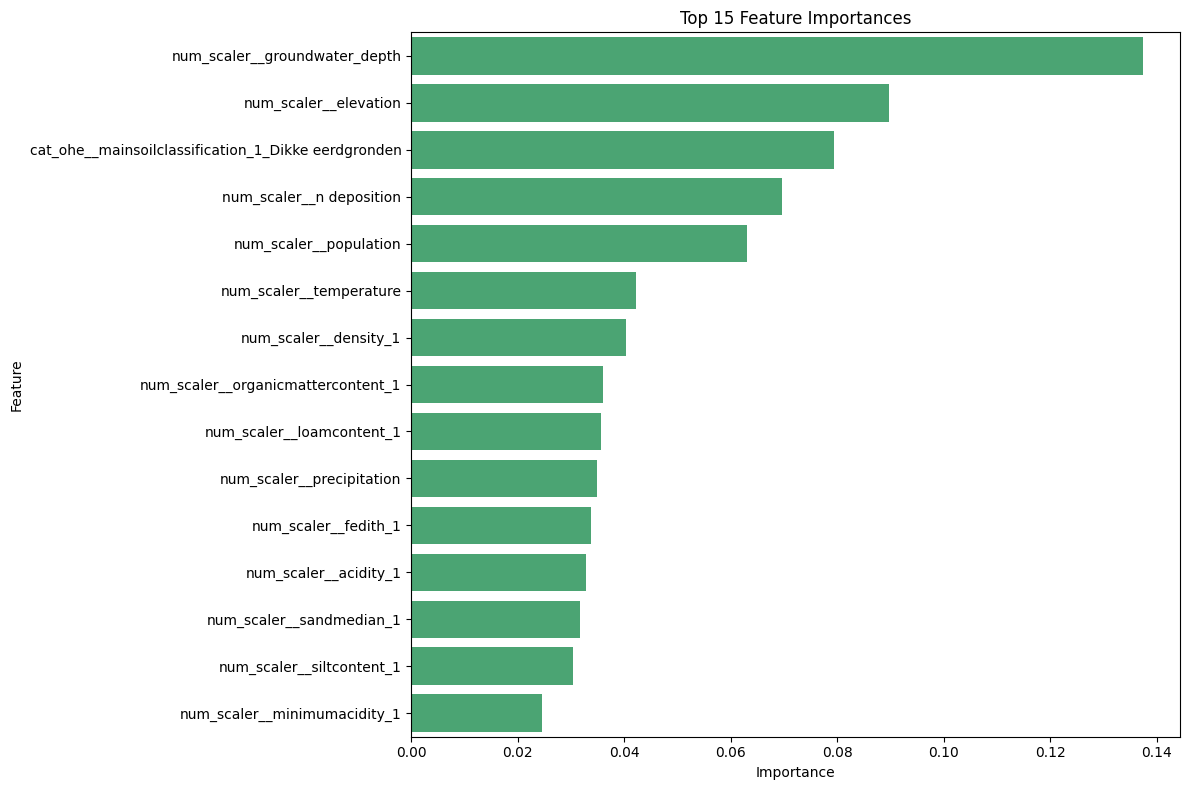

In [305]:
plt.figure(figsize=(12, 8))
sns.barplot(
    x="importance",    # <-- lowercase
    y="feature",       # <-- lowercase
    data=importance_df.head(15),
    color="mediumseagreen"
)
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [306]:
inner_pipeline = best_model.regressor_
fitted_preprocessor = inner_pipeline.named_steps['prep']
fitted_model = inner_pipeline.named_steps['rf']

feature_names = fitted_preprocessor.get_feature_names_out()

importances = fitted_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

ValueError: All arrays must be of the same length

In [1701]:
# Build and plot the importance DataFrame
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x="Feature", y="Importance", data=fi_df.head(10), color="mediumseagreen")
plt.xticks(rotation=45, ha='right')
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()


ValueError: All arrays must be of the same length

In [429]:
# --- Keep:
# organiccontent
# elevation
# soil code
# acidity
# groundwater depth
# density
# population
# precipitation
# n_deposition
# temperature

# --- Remove:
# landuse
# soil region
# month

# Model-Agnostic

In [430]:
# Transform X_test using preprocessor
X_test_transformed = fitted_preprocessor.transform(X_test)
y_test_true = y_test

  0%|          | 0/50 [00:00<?, ?it/s]

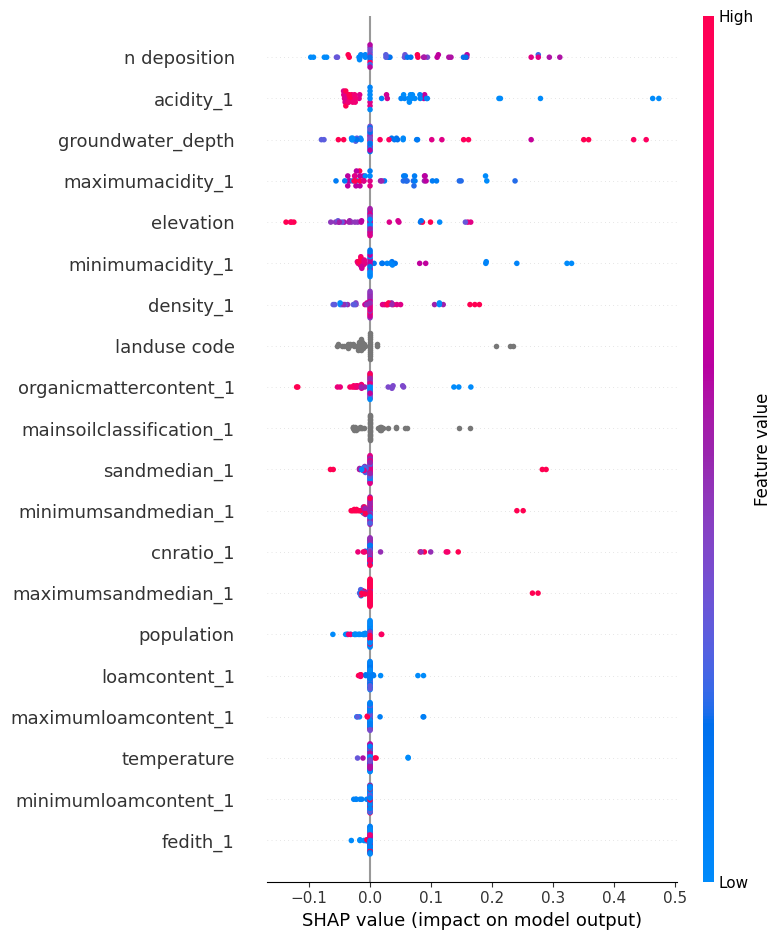

In [431]:
# Use minimal SHAP setup (no deep or tree models)
from shap.explainers import Kernel
import lime.lime_tabular
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Safe SHAP wrapper
def shap_predict(X_array):
    X_df = pd.DataFrame(X_array, columns=X_test.columns)
    return best_model.predict(X_df)

# Background data
X_background = X_train.sample(100, random_state=0)
explainer_shap = Kernel(shap_predict, X_background)
shap_values = explainer_shap.shap_values(X_test.iloc[:50])

# SHAP plot
import shap
shap.summary_plot(shap_values, X_test.iloc[:50])

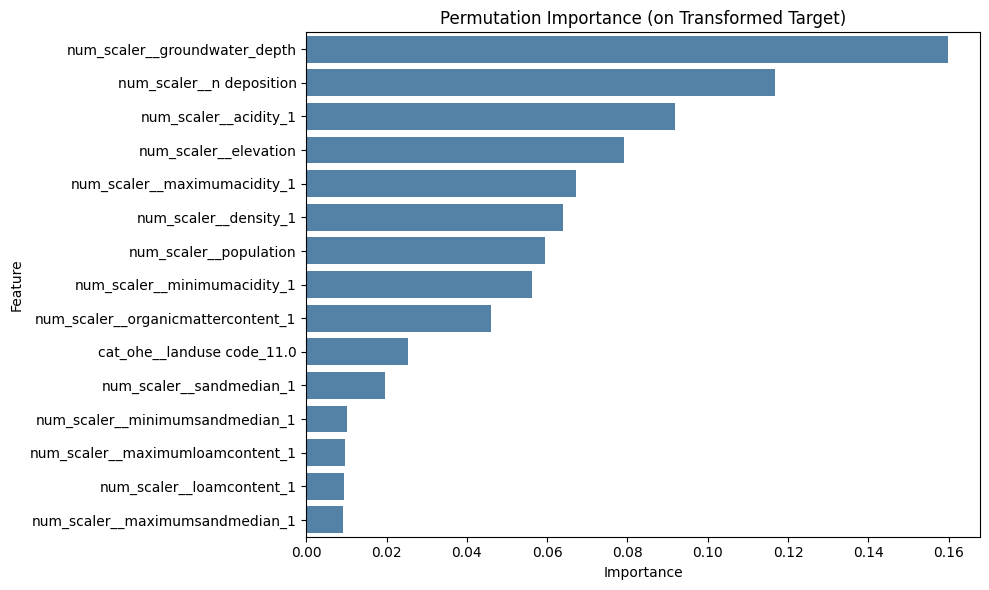

In [432]:
# If your target was transformed using log1p, reverse it before comparing
if isinstance(best_model, TransformedTargetRegressor):
    y_test_true = np.log1p(y_test)

# Run permutation importance
perm_result = permutation_importance(
    fitted_model, 
    X_test_transformed, 
    y_test_true,
    n_repeats=10,
    random_state=42,
    scoring="r2"
)

perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_result.importances_mean,
    "Std": perm_result.importances_std
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=perm_df.head(15), color="steelblue")
plt.title("Permutation Importance (on Transformed Target)")
plt.tight_layout()
plt.show()


perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_result.importances_mean
}).sort_values("Importance", ascending=False)

perm_df["Importance"] /= perm_df["Importance"].sum()
perm_df["Type"] = "permutation"
